🚀 Running on device: cuda
📦 Loading CIFAR-10 Data...
🔥 Phase 4.5 Training Started... (Moderate Noise)
Epoch 1: Acc=25.35% | Loss=2.0780 | Teleports=24242
Epoch 2: Acc=30.76% | Loss=1.9850 | Teleports=24242
Epoch 3: Acc=32.63% | Loss=1.9801 | Teleports=24242
Epoch 4: Acc=33.40% | Loss=1.9878 | Teleports=24242
Epoch 5: Acc=34.05% | Loss=1.9784 | Teleports=24242
✅ Phase 4.5 Complete!


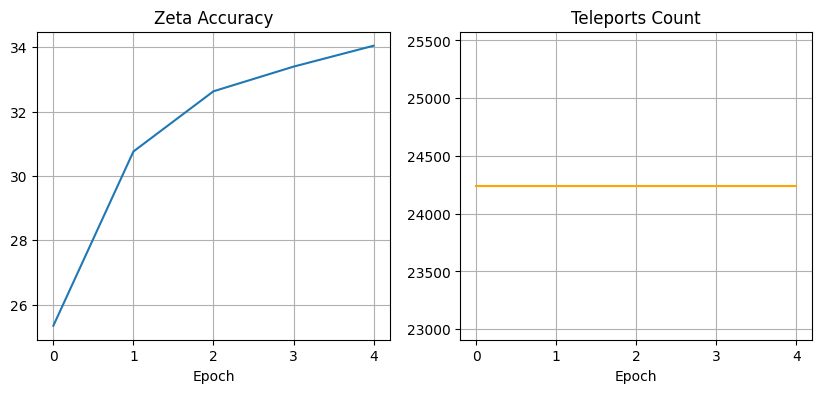

In [ ]:
# --- Phase 4.5: Zeta-Vision Tuned (The Redemption Run) ---
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt

# 1. 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Running on device: {device}")

# 2. 准备数据
print("📦 Loading CIFAR-10 Data...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 下载并加载训练集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

# 3. 定义 Zeta 优化器 (Vision Tuned)
class ZetaAdamW_VisionTuned(optim.AdamW):
    def __init__(self, params, lr=1e-3, zeta_teleport_thresh=0.5):
        super().__init__(params, lr=lr)
        self.zeta_teleport_thresh = zeta_teleport_thresh
        self.teleport_count = 0

    @torch.no_grad()
    def step(self, closure=None):
        loss = super().step(closure)
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                grad_norm = torch.norm(p.grad)

                # 当梯度模长超过阈值时，触发 Zeta 瞬移
                if grad_norm > self.zeta_teleport_thresh:
                    unit_grad = p.grad / (grad_norm + 1e-9)
                    p.data.sub_((1.0 / 12.0) * unit_grad)
                    self.teleport_count += 1
        return loss

# 4. 初始化模型与训练环境
model_vision_tuned = resnet18(num_classes=10).to(device)
opt_vision_tuned = ZetaAdamW_VisionTuned(model_vision_tuned.parameters(), lr=1e-3, zeta_teleport_thresh=0.5)
criterion = nn.CrossEntropyLoss()

logs_tuned = {'acc': [], 'loss': [], 'teleports': []}

# 5. 开始训练循环
print("🔥 Phase 4.5 Training Started... (Moderate Noise)")

for epoch in range(5): # 跑 5 个 Epoch 验证效果
    model_vision_tuned.train()
    running_loss = 0.0
    correct = 0
    total = 0
    opt_vision_tuned.teleport_count = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        opt_vision_tuned.zero_grad()
        outputs = model_vision_tuned(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # ---注入 0.5x 梯度噪声 ---
        with torch.no_grad():
            for p in model_vision_tuned.parameters():
                if p.grad is not None:
                    noise = torch.randn_like(p.grad) * 0.5
                    p.grad.add_(noise)

        # 执行优化 (含瞬移)
        opt_vision_tuned.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_acc = 100. * correct / total
    logs_tuned['acc'].append(epoch_acc)
    logs_tuned['teleports'].append(opt_vision_tuned.teleport_count)

    print(f"Epoch {epoch+1}: Acc={epoch_acc:.2f}% | Loss={running_loss/len(trainloader):.4f} | Teleports={opt_vision_tuned.teleport_count}")

print("✅ Phase 4.5 Complete!")

# 6. 绘图验证
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.plot(logs_tuned['acc']); plt.title('Zeta Accuracy'); plt.xlabel('Epoch'); plt.grid(True)
plt.subplot(1,2,2); plt.plot(logs_tuned['teleports'], color='orange'); plt.title('Teleports Count'); plt.xlabel('Epoch'); plt.grid(True)
plt.show()